# (Basic) LSTM & Pre-trained GloVe 

In [1]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
# define documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# load the whole embedding into memory
embeddings_index = dict()
f = open('../data/glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

[[6, 2], [3, 1], [7, 4], [8, 1], [9], [10], [5, 4], [11, 3], [5, 1], [12, 13, 2, 14]]
[[ 6  2  0  0]
 [ 3  1  0  0]
 [ 7  4  0  0]
 [ 8  1  0  0]
 [ 9  0  0  0]
 [10  0  0  0]
 [ 5  4  0  0]
 [11  3  0  0]
 [ 5  1  0  0]
 [12 13  2 14]]
Loaded 400000 word vectors.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            1500      
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 401       
Total params: 1,901
Trainable params: 401
Non-trainable params: 1,500
_________________________________________________________________
None
Accuracy: 100.000000


# LSTM학습. GLOVE임베딩을 사용한다. 
### tokenize: use split()

In [1]:
from utils import read_vocab, count_parameters, load_glove
import numpy as np 
import pandas as pd
import nltk
import itertools
import pickle

def read_files(data_dir, type_):
    train = pd.read_csv(data_dir+type_+'train.tsv', sep='\t')
    dev = pd.read_csv(data_dir+type_+'dev.tsv', sep='\t')
    test = pd.read_csv(data_dir+type_+'test.tsv', sep='\t')
    return train, dev, test

In [2]:
def w2seq(vocab, doc):
    max_len=100
    mapped_doc = pd.DataFrame()
    for sent in doc['text']:
        
        sample = [vocab.get(word, 1) for word in sent.split()]
        #zero padding 
        sample = np.pad(sample, (max_len-len(sample),0), mode='constant')
        
#         for word in sent.split():
#             if vocab.get(word, 1) == 1: print(word, " is not in corpus.")    
        
        Dict = dict.fromkeys(range(100),0)
        for i in range(max_len):
            Dict[i] = sample[i]
        mapped_doc = mapped_doc.append(Dict, ignore_index = True)
#     print(mapped_doc)
    mapped_doc['label'] = doc['label']
    return mapped_doc

In [11]:
from tensorflow.python.keras.datasets import reuters
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Embedding, Dropout
from keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import load_model
from tqdm import tqdm
import tensorflow as tf
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import load_model
from keras.utils.np_utils import to_categorical
from numpy import zeros
from tensorflow import keras
from keras.optimizers import SGD, Adam 
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

def train_model(train, dev, vocab, data_dir, result_dir, type_):
    
    #default emb_size: 200
    max_length = 100
    n_classes = 3
    emb_size = 200
    batch_size = 10
    epoch_size = 80
     #return embedding matrix dictionary.
    glove_embs = load_glove(data_dir+'glove.6B.{}d.txt'.format(emb_size), emb_size, vocab)
    #print(glove_embs)
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
    mc = ModelCheckpoint(result_dir+type_+'lstm_model.h5', monitor='val_acc',mode='max', 
                     verbose=0, save_best_only=True)

    with tf.device('/CPU:0'):

        model = Sequential()
        #Embedding(number of samples(단어 사전 크기), hidden layer size)
        e = Embedding(len(vocab), emb_size, weights=[glove_embs], input_length=max_length, trainable=False)
        model.add(e) 
        #batch norm. 의미 없음. activation func.이 tanh라서 output 값이 이미 정규화 됨. 
        #lstm 에서는 relu를 사용하지 않는다. 데이터나 모델에 부적절함. 큰값의 출력이 시계열 데이터의 변동성을 크게 한다. 
        model.add(LSTM(emb_size, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(emb_size, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(emb_size))
        model.add(Dense(n_classes, activation='softmax'))
        
        #initial_learning_rate * decay_rate ^ (step / decay_steps)
#         lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=3e-4, 
#                                                               decay_steps=100, decay_rate=0.4)
#         #default : learning_rate=0.001
#         opt = keras.optimizers.Adam(learning_rate=lr_schedule)
        opt = Adam(learning_rate=3e-4)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
        model.summary()
        
        [print(i.shape, i.dtype) for i in model.inputs]
        [print(o.shape, o.dtype) for o in model.outputs]
        [print(l.name, l.input_shape, l.dtype) for l in model.layers]
#         print(train, to_categorical(train_['label'], num_classes=n_classes))
#         print(dev, to_categorical(dev_['label'], num_classes=n_classes))
        history = model.fit(train.iloc[:,:-1], to_categorical(train['label'], num_classes=n_classes), batch_size=batch_size, epochs=epoch_size, 
                            verbose=1, callbacks=[es, mc], 
                            validation_data=(dev.iloc[:,:-1], to_categorical(dev['label'], num_classes=n_classes)))


In [4]:
def train_model2(train, dev, vocab, data_dir, result_dir, type_):
      
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
    mc = ModelCheckpoint(result_dir+type_+'lstm_model.h5', monitor='val_acc',mode='max', 
                     verbose=0, save_best_only=True)

    
    with tf.device('/CPU:0'):
        hidden=100

        model = Sequential()
        #Embedding(number of samples(단어 사전 크기), hidden layer size)
        model.add(Embedding(len(vocab), hidden))
        model.add(LSTM(hidden, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(hidden, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(hidden))
        model.add(Dense(3, activation='softmax'))
        opt = Adam(learning_rate=3e-4)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
        history = model.fit(train.iloc[:,:-1], to_categorical(train['label'], num_classes=3), batch_size=10, epochs=80, 
                            verbose=1, callbacks=[es, mc], 
                            validation_data=(dev.iloc[:,:-1],to_categorical(dev['label'], num_classes=3)))
        model.summary()
        #scores = model.evaluate(X[val], to_categorical(Y[val], num_classes=3), verbose=0)
        #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        #cvscores.append(scores[1] * 100)
        #model.save_weights('check_points/val'+str(num))

    #print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [5]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn

def test_result(title, test, result_dir, type_):
    re_model = load_model(result_dir+type_+'lstm_model.h5')
    y_pred = re_model.predict_classes(test.iloc[:,:-1])

    target_names=['0', '1', '2']
    print("Accuracy:", metrics.accuracy_score(test['label'], y_pred))
    print(classification_report(test['label'], y_pred, target_names=target_names))

    data_= {'y_Actual': test['label'], 'y_Predicted': y_pred}
    df_cm = pd.DataFrame(data_, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df_cm['y_Actual'], df_cm['y_Predicted'],
                                   rownames=['Actual'], colnames=['Predicted'])

    sn.heatmap(confusion_matrix, annot=True)
    plt.savefig(title+'cm.png', box_inches='tight')
    plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [6]:
def main(data_dir, result_dir, type_):
    train_, dev_, test_ = read_files(data_dir, type_)
    print("train sample: ", train_.shape[0])
    #print(train_)
    
    #TFIDF 이후 w2i.pkl파일 생성된 상태.
    vocab = read_vocab(data_dir+ type_+'w2i.pkl') #return word_to_index dictionary.
    train = w2seq(vocab, train_ )
    dev = w2seq(vocab, dev_ )
    test = w2seq(vocab, test_)
    
    train_model(train, dev, vocab, data_dir, result_dir, type_)
    
    title = result_dir+type_
    test_result(title, test, result_dir, type_ )
    
        

In [7]:
data_dir = "../data/"
result_dir = "./lstm_result/"
type_ = ['uneven-even/', 'even-even/', 'upeven-even/']

In [12]:
main(data_dir, result_dir, type_[0])

train sample:  1196
Loading vocabulary ...
Vocabulary size = 1527
Loading Glove pre-trained word embeddings ...
Total 400000 word vectors in ../data/glove.6B.200d.txt
Number of OOV words = 730
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          305400    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 200)          320800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 200)          320800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 200)          0         
___________________________________________________________

KeyboardInterrupt: 

train sample:  1196
Loading vocabulary ...
Vocabulary size = 1527
Loading Glove pre-trained word embeddings ...
Total 400000 word vectors in ../data/glove.6B.200d.txt
Number of OOV words = 730
(None, 100) <dtype: 'float32'>
(None, 3) <dtype: 'float32'>
embedding_23 (None, 100) float32
lstm_64 (None, 100, 200) float32
dropout_42 (None, 100, 200) float32
lstm_65 (None, 100, 200) float32
dropout_43 (None, 100, 200) float32
lstm_66 (None, 100, 200) float32
dense_23 (None, 200) float32
Epoch 1/80
120/120 [==============================] - 29s 242ms/step - loss: 0.6070 - acc: 0.7952 - val_loss: 1.3134 - val_acc: 0.3611
Epoch 2/80
120/120 [==============================] - 31s 258ms/step - loss: 0.4624 - acc: 0.8202 - val_loss: 1.0036 - val_acc: 0.5278
Epoch 3/80
120/120 [==============================] - 30s 250ms/step - loss: 0.4327 - acc: 0.8278 - val_loss: 1.1082 - val_acc: 0.4444
Epoch 4/80
120/120 [==============================] - 30s 250ms/step - loss: 0.3413 - acc: 0.8763 - val_loss:

/home/yoonjin/anaconda3/envs/medinfo/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


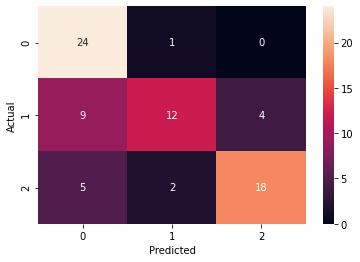

In [59]:
main(data_dir, result_dir, type_[0])

train sample:  270
Loading vocabulary ...
Vocabulary size = 994
Loading Glove pre-trained word embeddings ...
Total 400000 word vectors in ../data/glove.6B.200d.txt
Number of OOV words = 424
(None, 100) <dtype: 'float32'>
(None, 3) <dtype: 'float32'>
embedding_19 (None, 100) float32
lstm_52 (None, 100, 200) float32
dropout_34 (None, 100, 200) float32
lstm_53 (None, 100, 200) float32
dropout_35 (None, 100, 200) float32
lstm_54 (None, 100, 200) float32
dense_19 (None, 200) float32
Epoch 1/80
27/27 [==============================] - 6s 237ms/step - loss: 1.0934 - acc: 0.3926 - val_loss: 1.0388 - val_acc: 0.6111
Epoch 2/80
27/27 [==============================] - 6s 219ms/step - loss: 0.9957 - acc: 0.5704 - val_loss: 0.8890 - val_acc: 0.5556
Epoch 3/80
27/27 [==============================] - 6s 221ms/step - loss: 0.8440 - acc: 0.6259 - val_loss: 0.7842 - val_acc: 0.6667
Epoch 4/80
27/27 [==============================] - 6s 220ms/step - loss: 0.6945 - acc: 0.7074 - val_loss: 0.7166 - val_

/home/yoonjin/anaconda3/envs/medinfo/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


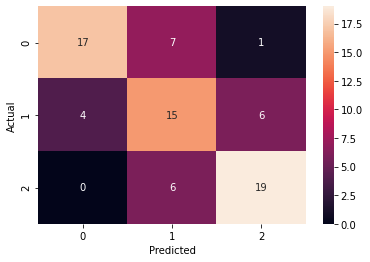

In [51]:
main(data_dir, result_dir, type_[1])

train sample:  435
Loading vocabulary ...
Vocabulary size = 1091
Loading Glove pre-trained word embeddings ...
Total 400000 word vectors in ../data/glove.6B.200d.txt
Number of OOV words = 473
(None, 100) <dtype: 'float32'>
(None, 3) <dtype: 'float32'>
embedding_20 (None, 100) float32
lstm_55 (None, 100, 200) float32
dropout_36 (None, 100, 200) float32
lstm_56 (None, 100, 200) float32
dropout_37 (None, 100, 200) float32
lstm_57 (None, 100, 200) float32
dense_20 (None, 200) float32
Epoch 1/80
44/44 [==============================] - 11s 258ms/step - loss: 1.0702 - acc: 0.4414 - val_loss: 0.9614 - val_acc: 0.5833
Epoch 2/80
44/44 [==============================] - 11s 250ms/step - loss: 0.8625 - acc: 0.5816 - val_loss: 0.8194 - val_acc: 0.6389
Epoch 3/80
44/44 [==============================] - 11s 247ms/step - loss: 0.6787 - acc: 0.7034 - val_loss: 0.7023 - val_acc: 0.6944
Epoch 4/80
44/44 [==============================] - 11s 249ms/step - loss: 0.5858 - acc: 0.7586 - val_loss: 0.7652 -

/home/yoonjin/anaconda3/envs/medinfo/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


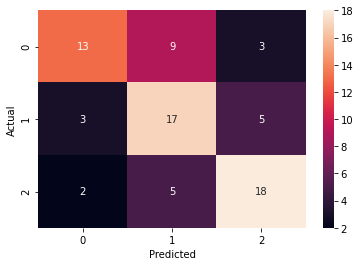

In [52]:
main(data_dir, result_dir, type_[2])